## ***Vehicle Detection Project***

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

In [1]:
# import all necessary packages used in the functions
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

the number of vehicle images: 8792
the number of non-vehicle images: 8968
The shape of image: (64, 64, 3)


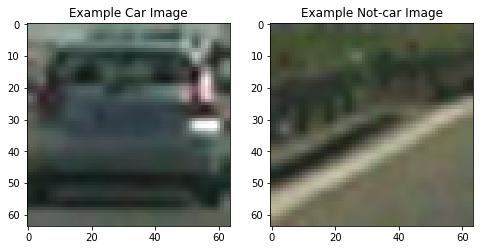

In [2]:

## import the vehicle images from small dataset
#vehicle_location=glob.glob('./data/vehicles_smallset/*/*.jpeg')
vehicle_location=glob.glob('./data/vehicles/*/*.png')
non_vehicle_location=glob.glob('./data/non-vehicles/*/*.png')
#non_vehicle_location=glob.glob('./data/non-vehicles_smallset/*/*.jpeg')
print('the number of vehicle images:', len(vehicle_location))
print('the number of non-vehicle images:', len(non_vehicle_location))
cars_img=[]
notcars_img=[]
for file in vehicle_location:
    img=cv2.imread(file)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cars_img.append(img)
    
for file in non_vehicle_location:
    img=cv2.imread(file)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    notcars_img.append(img)
    
    

# Plot the examples ################################
car_image=cars_img[np.random.randint(0,len(cars_img))]
notcar_image=notcars_img[np.random.randint(0,len(notcars_img))]
fig = plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
print('The shape of image:', car_image.shape)

The shape of car image: (64, 64, 3)
The length of color feature vectors: 96
The length of spatial feature vectors: 3072
The length of hog feature vectors: 1764
The length of all feature vectors: 8460


Text(0.5,1,'Hog feature of all channels (YCrCb)')

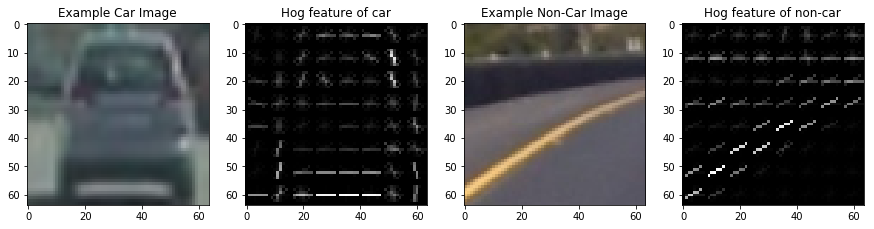

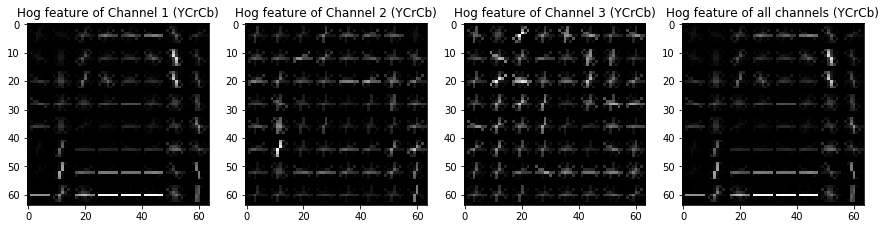

In [3]:
def hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vct=True):
    if vis==True:
        feature, hog_image=hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualize=vis, feature_vector=feature_vct, block_norm='L2-Hys',transform_sqrt=True)
        return feature, hog_image
        
    else:
        feature=hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),visualize=vis, feature_vector=feature_vct, block_norm='L2-Hys',transform_sqrt=True)
        return feature
## get the color histogram feaures
def color_hist(img, nbins=32, bin_range=(0,256)):
    channel1=np.histogram(img[:,:,0], bins=nbins, range=bin_range)
    channel2=np.histogram(img[:,:,1], bins=nbins, range=bin_range)
    channel3=np.histogram(img[:,:,2], bins=nbins, range=bin_range)
    color_feature=np.concatenate((channel1[0],channel2[0],channel3[0]))
    return color_feature

## get spatial feaure
def spatial_feature(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def extract_features(img, color_space='RGB', hog_channel=0):
    # define the overall feature list containing hog feature, color histogram, as well as spatial feature
    feature=[]
    # if the color space of image is not RGB, then covert it into HLS, HSV, YCrCb, LUV, YUV
    if color_space!='RGB':
        if color_space=='HLS':
            color_img=cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space=='HSV':
            color_img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space=='YCrCb':
            color_img=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space=='LUV':
            color_img=cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space=='YUV':
            color_img=cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    else:
        color_img=np.copy(img)
    if hog_channel=='All':
        hog_feature_list=[]
        for ch in range(0, 3):
            HOG_feature=hog_feature(color_img[:,:,ch], orient, pix_per_cell, cell_per_block, vis=False, feature_vct=True)
            hog_feature_list.append(HOG_feature)
        hog_features=np.concatenate((hog_feature_list))
    else:
        hog_features=hog_feature(color_img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vct=True)
    color_feature=color_hist(img, nbins, bin_range)
    spa_feature=spatial_feature(img, size)
    feature=np.concatenate((hog_features,color_feature,spa_feature))
    return feature


# Plot the examples ################################
## Define all parameters of functions:
orient=9
pix_per_cell=8
cell_per_block=2
vis=True
nbins=32
bin_range=(0,256)
size=(32,32)
color_space='YCrCb'
hog_channel='All'

ind=np.random.randint(0,len(cars_img))
car_image=cars_img[5]
notcar_image=notcars_img[5]
car_feature, hog_car_image=hog_feature(car_image, orient, pix_per_cell, cell_per_block, vis=vis, feature_vct=True)
noncar_feature, non_hog_image=hog_feature(notcar_image, orient, pix_per_cell, cell_per_block, vis=vis, feature_vct=True)

all_feature=extract_features(car_image, color_space, hog_channel)
color_feature=color_hist(car_image, nbins, bin_range)
space_feature=spatial_feature(car_image, size)
print('The shape of car image:',car_image.shape)
print('The length of color feature vectors:',len(color_feature))
print('The length of spatial feature vectors:',len(space_feature))
print('The length of hog feature vectors:',len(car_feature))
print('The length of all feature vectors:',len(all_feature))

#### plot the hog features of example images
fig = plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(hog_car_image, cmap='gray')
plt.title('Hog feature of car')
plt.subplot(143)
plt.imshow(notcar_image)
plt.title('Example Non-Car Image')
plt.subplot(144)
plt.imshow(non_hog_image, cmap='gray')
plt.title('Hog feature of non-car')
### convert the image to YCrCb color
color_img=cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)
ch1_feature, ch1_image=hog_feature(color_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vct=True)
ch2_feature, ch2_image=hog_feature(color_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vct=True)
ch3_feature, ch3_image=hog_feature(color_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vct=True)
all_feature, all_image=hog_feature(color_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vct=True)
fig=plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(ch1_image, cmap='gray')
plt.title('Hog feature of Channel 1 (YCrCb)')
plt.subplot(142)
plt.imshow(ch2_image, cmap='gray')
plt.title('Hog feature of Channel 2 (YCrCb)')
plt.subplot(143)
plt.imshow(ch3_image, cmap='gray')
plt.title('Hog feature of Channel 3 (YCrCb)')
plt.subplot(144)
plt.imshow(all_image, cmap='gray')
plt.title('Hog feature of all channels (YCrCb)')


In [45]:
"""
define a function to find the best parameters for non-linear SVM with 'rbf' kernel
"""
def svm_param_selection(X,y,nfold):
    Cs=[0.1, 1, 10]
    param_grid={'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
    clf =grid_search.GridSearchCV(svm.SVC(), param_grid, cv=nfold)
    clf.fit(X,y)
    clf.best_params_
    return clf.best_params_

In [46]:

"""
## Train Linear SVM using smallest vehicel and non-vehicles data
# extract all features from cars and noncars dataset
"""
cars_features=[]
noncars_features=[]

sample_size=np.amin(np.array([len(cars_img), len(notcars_img)])) 
#sample_size=8750
cars_img_data=[]
noncars_data=[]      
cars_img_data=cars_img[0:sample_size]
noncars_data=notcars_img[0:sample_size]
for img in cars_img_data:
    features=extract_features(img, color_space, hog_channel)
    cars_features.append(features)
for img in noncars_data:
    features=extract_features(img, color_space, hog_channel)
    noncars_features.append(features)    
print('the length of cars feature vectors', np.array(cars_features).shape)
## split the training data and testing dataset
X=np.vstack((cars_features, noncars_features)).astype(np.float64)
y=np.hstack((np.ones(len(cars_features)), np.zeros(len(noncars_features))))
"""
shuffle the whoe dataset with labels
"""
X_data, y_label=shuffle(X, y)
rand_state=np.random.randint(0,100)
X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2,  random_state=rand_state)
# fit the scaler
X_scaler=StandardScaler().fit(X_train)
X_train=X_scaler.transform(X_train)
X_test=X_scaler.transform(X_test)
#best_para=svm_param_selection(X_train,y_train,3)
#print(best_para)
#print(X_scaler)
"""
Save the scaler into local pickle file 
"""
scalerfile = 'scaler.sav'
pickle.dump(X_scaler, open(scalerfile, 'wb'))


the length of cars feature vectors (8792, 8460)


## Train SVM

In [47]:
# use the linear SVM, linear SVM is faster than non-linear kernel SVM

svc=LinearSVC()
#svc=svm.SVC(kernel='rbf', C=10)
t=time.time()
svc.fit(X_train, y_train)
t1=time.time()
print('the seconds of training SVM:', round(t1-t))
# check the accuracy of the testing data
print('the accuracy of SVC=',round(svc.score(X_test,y_test),4))
# predict the trained SVM model on the test dataset
n_predict=20
test_accu=svc.predict(X_test[0:n_predict])
print('My SVC predicts: ', test_accu)
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

scalerfile = 'svc.sav'
pickle.dump(svc, open(scalerfile, 'wb'))



the seconds of training SVM: 4
the accuracy of SVC= 0.994
My SVC predicts:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
For these 20 labels:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.]


In [5]:
## the input of this function must be "BGR" channel of image
def covert_colors(img, color_space):
    if color_space=='HLS':
        color_img=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space=='HSV':
        color_img=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space=='YCrCb':
        color_img=cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color_space=='LUV':
        color_img=cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space=='YUV':
        color_img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return color_img


In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    ## adjust the size of window along with y axis
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [7]:
def findCars(img, windows, svc, scaler, y_start_stop=[400, 656]):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    windows_list = []
    #windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, color_space, hog_channel)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = svc.predict(scaled_features)
        if pred == 1:
            windows_list.append(window)
    return windows_list



In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [9]:
def car_detection(img, scale, svc, X_scaler,orient, cell_per_block, pix_per_cell, window=64, cells_per_step=2,  y_start=400, y_stop=656):
    img_copy=np.copy(img)
    img=img.astype(np.float32)/255
    img_search=img[y_start:y_stop,:,:]
    hsvimg=covert_colors(img_search, color_space='YCrCb')
    if scale!=1:
        imgshape = hsvimg.shape
        hsvimg=cv2.resize(hsvimg, (np.int(imgshape[1]/scale),np.int(imgshape[0]/scale)))
    
    ch1=hsvimg[:,:,0]
    ch2=hsvimg[:,:,1]
    ch3=hsvimg[:,:,2]
    nxblock=(ch1.shape[1]//pix_per_cell)-cell_per_block+1
    nyblock=(ch1.shape[0]//pix_per_cell)-cell_per_block+1
    ## define windows size
    # define the number of cells per step, which is the overlap of each step
    nblock_per_win=window//pix_per_cell-cell_per_block+1
    nxstep=(ch1.shape[1]//pix_per_cell-window//pix_per_cell)//cells_per_step+1
    nystep=(ch1.shape[0]//pix_per_cell-window//pix_per_cell)//cells_per_step+1    
    # get the HOG feature for each image channel
    hog1=hog_feature(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vct=False)
    hog2=hog_feature(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vct=False)
    hog3=hog_feature(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vct=False)
    #print('the shape of hog', np.array(hog1).shape)
    win_list=[]
    for nx in range(nxstep):
        for ny in range(nystep):
            xpos=nx*cells_per_step
            ypos=ny*cells_per_step
            hog1_win=hog1[ypos:(ypos+nblock_per_win), xpos:xpos+nblock_per_win].ravel()
            hog2_win=hog2[ypos:(ypos+nblock_per_win), xpos:xpos+nblock_per_win].ravel()
            hog3_win=hog3[ypos:(ypos+nblock_per_win), xpos:xpos+nblock_per_win].ravel()
            hog_features=np.concatenate((hog1_win, hog2_win, hog3_win))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(hsvimg[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = spatial_feature(subimg, size)
            hist_features = color_hist(subimg, nbins, bin_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((hog_features, hist_features, spatial_features)).reshape(1, -1)) 
            """
            The order of stacking hog features, histogram and spatial features must be the same as functions (extract_features)
            """
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(img_copy,(xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255),4) 
                win_list.append(((xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start)))
                
    return win_list

    

In [48]:
## import the example images and test the SVM on the example
files=glob.glob('./test_images/*.jpg')
test_img=[]
for filename in files:
    img=mpimg.imread(filename)
    test_img.append(img)
    
#plt.figure(figsize=(24,9))
#plt.subplot(231)
#plt.imshow(test_img[0])
#plt.subplot(232)
#plt.imshow(test_img[1])
#plt.subplot(233)
#plt.imshow(test_img[2])
#plt.subplot(234)
#plt.imshow(test_img[3])
#plt.subplot(235)
#plt.imshow(test_img[4])
#plt.subplot(236)
#plt.imshow(test_img[5])


In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

def heat_detection(img, bbox_list, threshold):
    heat=np.zeros_like(img[:,:,0]).astype(np.float64)
    heat=add_heat(heat, bbox_list)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    detected_img=draw_labeled_bboxes(np.copy(img), labels)
    return detected_img, heatmap


The number of windows: 400


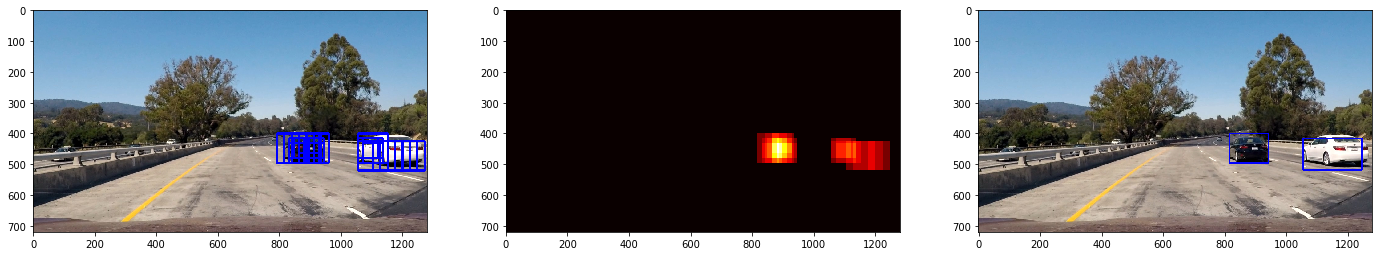

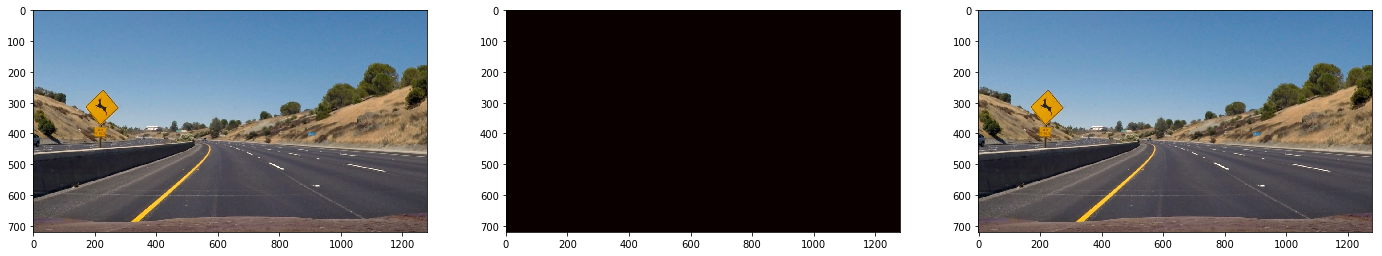

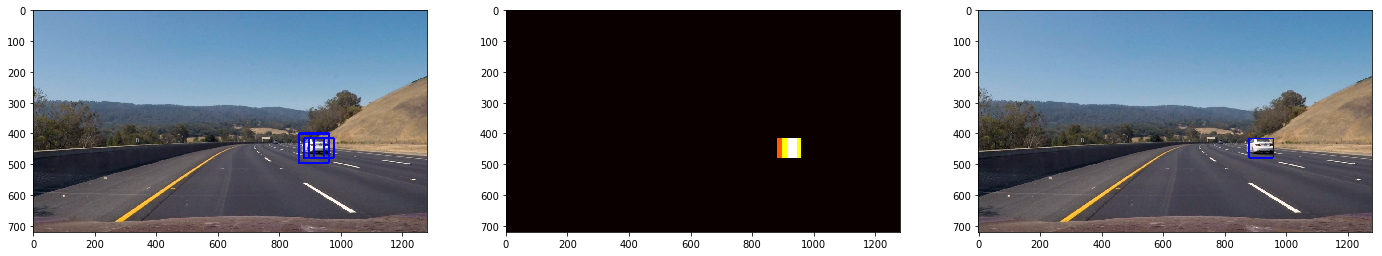

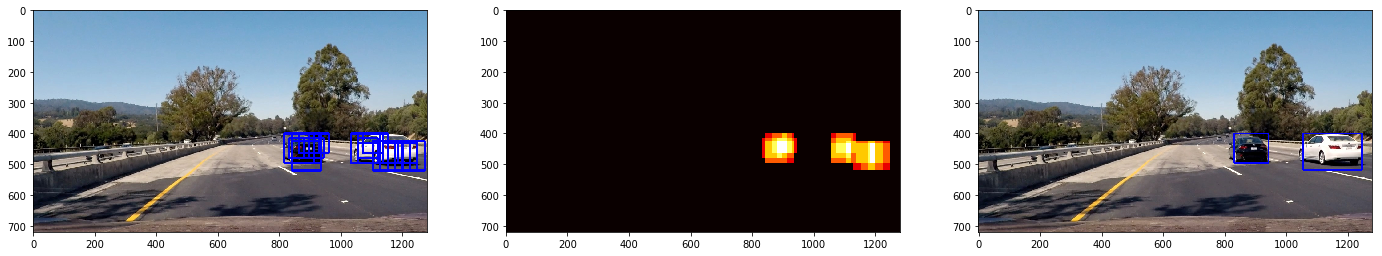

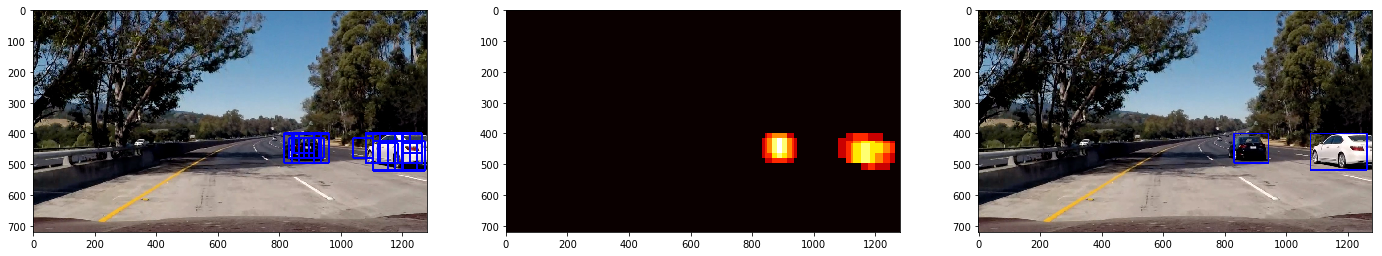

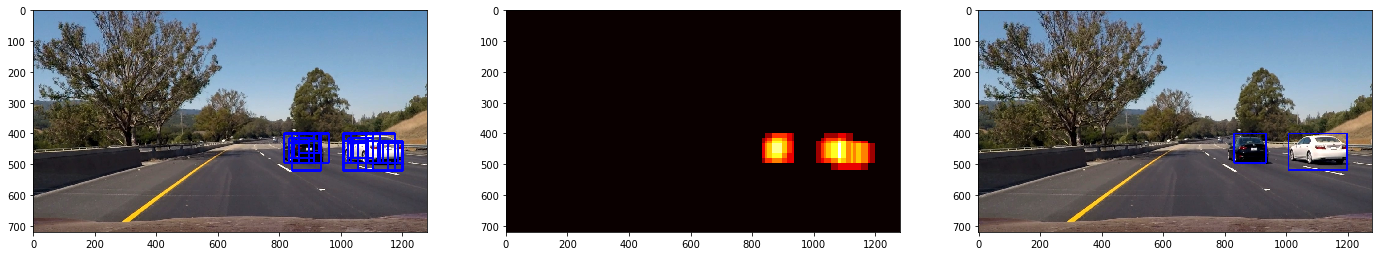

In [44]:

## Define all parameters of functions:
orient=9
pix_per_cell=8
cell_per_block=2
vis=True
nbins=32
bin_range=(0,256)
size=(32,32)
color_space='YCrCb'
hog_channel='All'
threshold=1
"""
Read X_scaler and svc from stored local pickle file
"""
scalerfile = 'scaler.sav'
X_scaler = pickle.load(open(scalerfile, 'rb'))
svcfile = 'svc.sav'
svc = pickle.load(open(svcfile, 'rb'))

#wind_list=slide_window(test_img[2], y_start_stop=[400, 656], 
                    #xy_window=(128, 128), xy_overlap=(0.75, 0.75))
#img_boxes=draw_boxes(test_img[2], wind_list, color=(0, 0, 255), thick=3)


img_final_list=[]
output_img_list=[]
heatmap_list=[]
for i in range(0,6):
    windows1=slide_window(test_img[i], y_start_stop=[400, 500], xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows2=slide_window(test_img[i], y_start_stop=[400, 550], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows3=slide_window(test_img[i], y_start_stop=[500, 656], xy_window =(128, 128), xy_overlap=(0.5, 0.5))
    windows1.extend(windows2)
    windows1.extend(windows3)

    wind_list1=findCars(test_img[i], windows1, svc, X_scaler, y_start_stop=[400, 656])

    img_final=draw_boxes(test_img[i], wind_list1, color=(0, 0, 255), thick=5)
    output_img, heatmap=heat_detection(test_img[i], wind_list1, threshold)
    img_final_list.append(img_final)
    output_img_list.append(output_img)
    heatmap_list.append(heatmap)
print('The number of windows:', len(windows1))    

f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[0])
ax2.imshow(heatmap_list[0], cmap='hot')
ax3.imshow(output_img_list[0])


f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[1])
ax2.imshow(heatmap_list[1], cmap='hot')
ax3.imshow(output_img_list[1])

f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[2])
ax2.imshow(heatmap_list[2], cmap='hot')
ax3.imshow(output_img_list[2])

f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[3])
ax2.imshow(heatmap_list[3], cmap='hot')
ax3.imshow(output_img_list[3])

f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[4])
ax2.imshow(heatmap_list[4], cmap='hot')
ax3.imshow(output_img_list[4])

f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(24,9))
ax1.imshow(img_final_list[5])
ax2.imshow(heatmap_list[5], cmap='hot')
ax3.imshow(output_img_list[5])




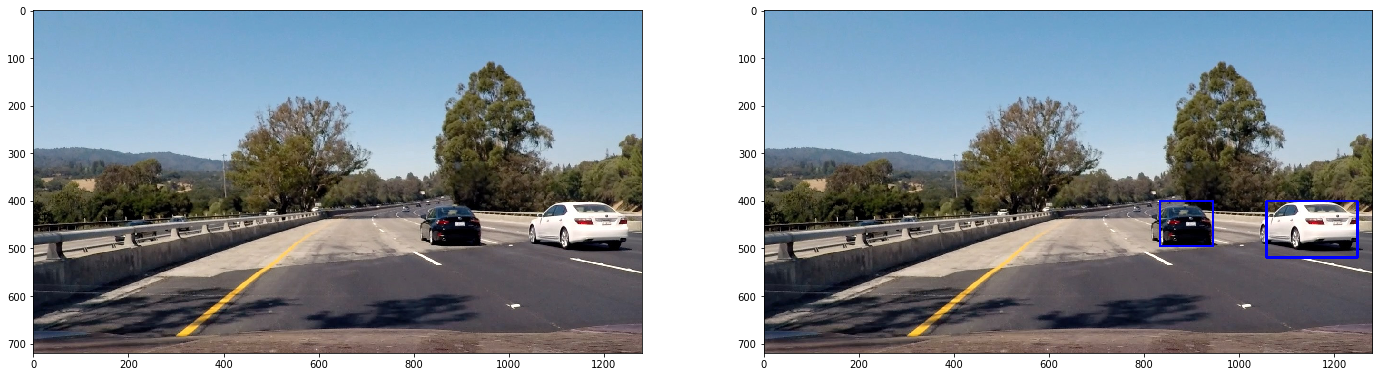

In [31]:
## Define pipeline 1 using sliding window functions
def pipeline1(img):
    threshold = 1 
    windows1=slide_window(img, y_start_stop=[400, 500], xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows2=slide_window(img, y_start_stop=[400, 550], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows3=slide_window(img, y_start_stop=[500, 656], xy_window =(128, 128), xy_overlap=(0.5, 0.5))
    windows1.extend(windows2)
    windows1.extend(windows3)

    wind_list1=findCars(img, windows1, svc, X_scaler, y_start_stop=[400, 656])

    img_final=draw_boxes(img, wind_list1, color=(0, 0, 255), thick=6)
    output_img, heatmap=heat_detection(img, wind_list1, threshold)
    return output_img

x_img=test_img[3]
output_img=pipeline1(x_img)
f, (ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(x_img)
ax2.imshow(output_img)



## Video Pipeline

In [30]:
# Defining a class to store the refined frames found from the last 15 frames

class SmoothWindows():
    def __init__(self):
        self.smoothwins = [] 
    def AverageWindows(self, Window):
        self.smoothwins.append(Window)
        frameHistory=15
        if len(self.smoothwins) > frameHistory:
            self.smoothwins = self.smoothwins[len(self.smoothwins)-frameHistory:]

In [32]:
## Define pipeline 1 using sliding window functions

smoothWindows = SmoothWindows()
def pipelineVideo(img):
    threshold = 1 
    windows1=slide_window(img, y_start_stop=[400, 500], xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows2=slide_window(img, y_start_stop=[400, 550], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows3=slide_window(img, y_start_stop=[500, 656], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows1.extend(windows2)
    windows1.extend(windows3)

    wind_list1=findCars(img, windows1, svc, X_scaler, y_start_stop=[400, 656])
    
# randomly create 0-1 value 
    rand= np.random.random_sample()
    if(rand<0.3):
        goodWindows=smoothWindows.smoothwins[:-1]
    else:
        goodWindows=wind_list1
        if len(goodWindows) > 0:
            smoothWindows.AverageWindows(goodWindows)
    heat=np.zeros_like(img[:,:,0]).astype(np.float64)
    for Window in smoothWindows.smoothwins:
        heat = add_heat(heat, Window)
    
    heatmap = apply_threshold(heat, 25 + len(smoothWindows.smoothwins)//2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


In [33]:
# Import everything needed to edit/save/watch video clips

def process_image(img):
    return pipelineVideo(img)

white_output = './output_video/test_video2.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
 

[MoviePy] >>>> Building video ./output_video/test_video2.mp4
[MoviePy] Writing video ./output_video/test_video2.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:17<00:02,  2.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/test_video2.mp4 

Wall time: 1min 18s
